# Symbolic Bifurcation Analysis 

This notebook is the **symbolic walkthrough** for the bifurcation analysis used in the paper and SI.
It is designed to be **source-of-truth**: all equations shown here are generated directly from `symbolic_problem.py`, so the SI and the code stay consistent.

**What you will find:**
- Constitutive model and damage functions.
- Base-state (axisymmetric) equilibrium: ODEs for $p_0'(r)$ and $\alpha_0''(r)$.
- Incremental problem for a circumferential mode $n$: the 6D first-order system (Eq. (45) in the main text).
- Boundary conditions in coefficient form (Eq. (52) in the main text): the $E_{ij}$ functions.

> **Notation:** we work in the **current configuration** with radial coordinate $r$. The regularization (gradient-damage) term is **pushed-forward**, so gradients involve the left Cauchy–Green tensor $\mathbf B=\mathbf F\mathbf F^\mathsf T$.


In [1]:
# --- Setup (local imports) ---
import sys
from pathlib import Path


# If you run this notebook from the repo root, this is not needed.
# If you run it from somewhere else, this ensures the local modules are importable.
this_dir = Path().resolve()
if str(this_dir) not in sys.path:
    sys.path.insert(0, str(this_dir))

import sympy as sp
from IPython.display import display, Math

# Local project modules (must be in the same folder or on PYTHONPATH)
sys.path.append('../')
from classes import *


Loading symbolic packages.


In [2]:
# Build the symbolic problem (this triggers the derivations)
sym = symbolic_problem.SymbolicProblem(material="NeoHookean", damage_model="AT2")


Symbolic problem initialized.


## Model parameters and fields

**Geometry**
- $A$ : inner radius in the reference configuration  
- $B$ : outer radius in the reference configuration  
- $a$ : inner radius in the current configuration (control via $\lambda_a=a/A$)  
- $b$ : outer radius in the current configuration (from incompressibility)

**Material & fracture**
- $\mu$ : shear modulus  
- $G_c$ : critical energy release rate  
- $\ell$ : phase-field length scale  
- (optional) $J_m$ : Gent limited-extensibility parameter (ignored for Neo-Hookean)

**Fields**
- Base pressure: $p_0(r)$  
- Base damage: $\alpha_0(r)$  
- Incremental displacement: $(v_r,v_\theta)(r,\theta)$  
- Incremental pressure: $p_1(r,\theta)$  
- Incremental damage: $\beta(r,\theta)$


## Constitutive response functions

### Kinematics (base state)
We assume an axisymmetric, incompressible cavity expansion where the **base state** depends only on the current radius $r$.
The base deformation gradient used in the code is
$$
\mathbf F_0(r)=\mathrm{diag}\!\left(\lambda_r(r),\lambda_\theta(r)\right)
=\mathrm{diag}\!\left(\frac{1}{\lambda(r)},\lambda(r)\right),
\qquad \det\mathbf F_0 = 1.
$$

This choice corresponds to plane strain incompressibility in the $(r,\theta)$-plane, and it is sufficient for the 2D bifurcation analysis in the paper.


In [3]:
# Display the base-state deformation gradient and invariants
display(Math(r"\mathbf F_0 = " + sp.latex(sym.F)))
display(Math(r"I_1 = " + sp.latex(sym.I1)))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

### Strain energy density (Neo-Hookean)

For the Neo-Hookean model,
$$
W(\mathbf F)=\frac{\mu}{2}\left(I_1-2\right),
\qquad I_1=\mathrm{tr}\left(\mathbf F^\mathsf T\mathbf F\right).
$$


In [4]:
display(Math(r"W(\mathbf F_0)= " + sp.latex(sym.strain_energy_density)))

<IPython.core.display.Math object>

### Damage functions (AT2)

We use:
$$
a(\alpha)=(1-\alpha)^2,\qquad w(\alpha)=\alpha^2,\qquad 
c_w := 4\int_0^1 \sqrt{w(\alpha)}\,d\alpha = 2.
$$

This convention (the prefactor 4) matches the implementation in `symbolic_problem.py` and the SI normalization used in the numerical code.

The damaged Cauchy stress is $\boldsymbol\sigma_0=a(\alpha)\,\boldsymbol\sigma_{\text{elastic}}$ (see `symbolic_problem.py`).


In [5]:
display(Math(r"a(\alpha) = " + sp.latex(sym.a)))
display(Math(r"w(\alpha) = " + sp.latex(sym.w)))
display(Math(r"c_w = " + sp.latex(sym.c_w)))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

### Pushed-forward damage gradient 

The fracture regularization term is written in the **reference** configuration as $\ell\,|\nabla_X \alpha|^2$.
To work in the **current** configuration, we push-forward the gradient:
$$
\nabla_X \alpha = \mathbf F^\mathsf T \nabla_x \tilde\alpha,
\qquad
|\nabla_X \alpha|^2 = \nabla_x \tilde\alpha\cdot (\mathbf F\mathbf F^\mathsf T)\,\nabla_x \tilde\alpha
= \nabla_x \tilde\alpha\cdot \mathbf B\,\nabla_x \tilde\alpha.
$$

In the code, this appears through the **geometric Laplacian**
$$
\nabla_e^2 \alpha := \nabla_x\cdot(\mathbf B\,\nabla_x \alpha).
$$
For the axisymmetric base state, $\nabla_x\alpha=(\alpha'(r),0)^\mathsf T$ and the code computes $\nabla_e^2\alpha$ explicitly in cylindrical coordinates.


In [6]:
# Reproduce the "geometric Laplacian" used in the base-state damage equation
r, th = sym.r, sym.theta
B = sym.F*sym.F.T
grad_alpha0 = sp.Matrix([sp.diff(sym.damage, r), 0])
q0 = B*grad_alpha0  # q0 = B ∇α

geo_lap_alpha0 = (1/r)*sp.diff(r*q0[0], r) + (1/r)*sp.diff(q0[1], th)  # θ-term drops in base state
display(Math(r"\mathbf B = \mathbf F_0\mathbf F_0^\mathsf T = " + sp.latex(B)))
display(Math(r"\nabla_e^2 \alpha_0 = " + sp.latex(sp.simplify(geo_lap_alpha0))))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

## Equilibrium equations

The base-state Cauchy stress is $\boldsymbol\sigma_0(r)$ and equilibrium in the **current** configuration reads
$$
\nabla_x\cdot\boldsymbol\sigma_0 = \mathbf 0.
$$
In cylindrical coordinates (axisymmetric), this yields a scalar first-order ODE for the pressure field $p_0(r)$:
$$
\frac{dp_0}{dr} = \texttt{dpdr}(r,\lambda(r),\alpha(r),\alpha'(r);\ell,\mu,G_c,\dots).
$$


In [7]:
display(Math(r"\frac{dp_0}{dr} = " + sp.latex(sym.dpdr)))


<IPython.core.display.Math object>

## Damage problem (base state)

The base-state damage equilibrium is obtained from the Euler–Lagrange equation for $\alpha$ (with irreversibility handled separately in the numerics).
In the current configuration (after push-forward), the strong form can be written as
$$
a'(\alpha)\,W(\mathbf F_0) + \frac{G_c}{c_w\,\ell}\Big(w'(\alpha) - 2\ell^2 \nabla_e^2\alpha\Big)=0,
\qquad \nabla_e^2\alpha=\nabla_x\cdot(\mathbf B\nabla_x\alpha).
$$
Solving this equation for $\alpha''(r)$ gives the explicit ODE used in the numerical shooting/BVP solver.


In [8]:
display(Math(r"\frac{d^2\alpha_0}{dr^2} = " + sp.latex(sym.dda)))


<IPython.core.display.Math object>

## Incremental mechanical equilibrium

We linearize about the base state and assume a circumferential Fourier mode $n$.
The code uses the ansatz
$$
v_r(r,\theta)=U(r)\sin(n\theta),\quad
v_\theta(r,\theta)=V(r)\cos(n\theta),\quad
p_1(r,\theta)=Q(r)\sin(n\theta),\quad
\beta(r,\theta)=B(r)\sin(n\theta).
$$

Using the incompressibility constraint to eliminate $V(r)$, and the incremental equilibrium equation in the circumferential direction to eliminate $Q(r)$, the remaining incremental radial equilibrium reduces to a coupled system for $U(r)$ and $B(r)$:
- a **4th-order** ODE for $U(r)$ (implemented in the code as an expression that returns $U''''$),
- a **2nd-order** ODE for $B(r)$ (implemented in the code as an expression that returns $B''$).

These reduced equations are stored as `sym.Fn2` (mechanical) and `sym.ea2` (damage) in the symbolic implementation.


### Reduced ODEs in coefficient form

The reduced **mechanical** ODE can be written as

$$
f_4(r)\,U^{(4)} + f_3(r)\,U^{(3)} + f_2(r)\,U'' + f_1(r)\,U' + f_0(r)\,U
+ f_1^d(r)\,B' + f_0^d(r)\,B = 0,
$$

where the functions $f_i(r)$ and $f_i^d(r)$ depend on the base state (including $\alpha_0(r)$ and $p_0(r)$).

The reduced **damage** ODE takes the form

$$
g_2(r)\,B'' + g_1(r)\,B' + g_0(r)\,B
+ g_2^e(r)\,U'' + g_1^e(r)\,U' + g_0^e(r)\,U = 0.
$$

Below we extract these coefficients directly from the symbolic expressions used in the code.


In [9]:

from IPython.display import display, Math, Markdown

r = sym.r
U = sym.U
B = sym.B

def collect_on_derivatives(expr, terms):
    """Expand + collect expression on the given derivative objects."""
    expr = smp.expand(expr)
    return smp.collect(expr, terms)

def coeff(expr, term):
    """Return coefficient of a given Derivative term (or symbol) in expr."""
    return smp.simplify(expr.coeff(term))

# ---------------------------------------------------------------------
# Mechanical reduced equation: sym.Fn2 = 0
# ---------------------------------------------------------------------
display(Markdown("**Mechanical reduced equation (`sym.Fn2 = 0`)**"))

terms_mech = [
    U.diff(r,4), U.diff(r,3), U.diff(r,2), U.diff(r,1), U,
    B.diff(r,1), B
]

Fn2c = collect_on_derivatives(sym.Fn2, terms_mech)
display(Markdown("Collected form:"))
display(Math(smp.latex(Fn2c)))

f4  = coeff(Fn2c, U.diff(r,4))
f3  = coeff(Fn2c, U.diff(r,3))
f2  = coeff(Fn2c, U.diff(r,2))
f1  = coeff(Fn2c, U.diff(r,1))
f0  = coeff(Fn2c, U)
f1d = coeff(Fn2c, B.diff(r,1))
f0d = coeff(Fn2c, B)

display(Markdown("**Extracted coefficients**"))
for name, val in [("f_4",f4),("f_3",f3),("f_2",f2),("f_1",f1),("f_0",f0),
                  ("f_1^d",f1d),("f_0^d",f0d)]:
    display(Math(rf"{name}(r)= {smp.latex(val)}"))

# Optional: verify exact reconstruction
Fn2_recon = f4*U.diff(r,4) + f3*U.diff(r,3) + f2*U.diff(r,2) + f1*U.diff(r,1) + f0*U + f1d*B.diff(r,1) + f0d*B
check_mech = smp.simplify(Fn2c - Fn2_recon)
display(Markdown("Reconstruction check (should be 0):"))
display(Math(smp.latex(check_mech)))

# ---------------------------------------------------------------------
# Damage reduced equation: sym.ea2 = 0
# ---------------------------------------------------------------------
display(Markdown("---\n**Damage reduced equation (`sym.ea2 = 0`)**"))

terms_dmg = [B.diff(r,2), B.diff(r,1), B, U.diff(r,2), U.diff(r,1), U]
ea2c = collect_on_derivatives(sym.ea2, terms_dmg)
display(Markdown("Collected form:"))
display(Math(smp.latex(ea2c)))

g2  = coeff(ea2c, B.diff(r,2))
g1  = coeff(ea2c, B.diff(r,1))
g0  = coeff(ea2c, B)
g2e = coeff(ea2c, U.diff(r,2))
g1e = coeff(ea2c, U.diff(r,1))
g0e = coeff(ea2c, U)

display(Markdown("**Extracted coefficients**"))
for name, val in [("g_2",g2),("g_1",g1),("g_0",g0),
                  ("g_2^e",g2e),("g_1^e",g1e),("g_0^e",g0e)]:
    display(Math(rf"{name}(r)= {smp.latex(val)}"))

# Optional: verify exact reconstruction
ea2_recon = g2*B.diff(r,2) + g1*B.diff(r,1) + g0*B + g2e*U.diff(r,2) + g1e*U.diff(r,1) + g0e*U
check_dmg = smp.simplify(ea2c - ea2_recon)
display(Markdown("Reconstruction check (should be 0):"))
display(Math(smp.latex(check_dmg)))


**Mechanical reduced equation (`sym.Fn2 = 0`)**

Collected form:

<IPython.core.display.Math object>

**Extracted coefficients**

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

Reconstruction check (should be 0):

<IPython.core.display.Math object>

---
**Damage reduced equation (`sym.ea2 = 0`)**

Collected form:

<IPython.core.display.Math object>

**Extracted coefficients**

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

Reconstruction check (should be 0):

<IPython.core.display.Math object>

### First-order matrix form (main text Eq. (45))

Define the state vector
$$
\mathbf y(r)=\begin{bmatrix}U\\U'\\U''\\U'''\\B\\B'\end{bmatrix}.
$$
From the mechanical reduced equation,
$$
U^{(4)}=-\frac{1}{f_4}\Big(f_3 U^{(3)}+f_2 U''+f_1 U'+f_0 U+f_1^d B' + f_0^d B\Big),
$$
and from the damage reduced equation,
$$
B''=-\frac{1}{g_2}\Big(g_1 B' + g_0 B + g_2^e U'' + g_1^e U' + g_0^e U\Big).
$$
This yields a first-order system
$$
\mathbf y'(r)=\mathcal{M}(r)\,\mathbf y(r),
$$
with $\mathcal{M}(r)$ constructed below directly from the extracted coefficients.


In [10]:
display(Math(r"U'''' = \sum_{j=1}^6 \mathcal{M}_{4j}\,y_j " ))
display(Math(r"B'' = \sum_{j=1}^6 \mathcal{M}_{6j}\,y_j " ))

# Build the first-order system y' = M(r) y
# y = [U, U', U'', U''', B, B']^T

M = smp.zeros(6,6)

# U' = y2, U'' = y3, U''' = y4
M[0,1] = 1
M[1,2] = 1
M[2,3] = 1

# U'''' row from mechanical equation
# U'''' = -(f0/f4)U -(f1/f4)U' -(f2/f4)U'' -(f3/f4)U''' -(f0d/f4)B -(f1d/f4)B'
M[3,0] = -f0/f4
M[3,1] = -f1/f4
M[3,2] = -f2/f4
M[3,3] = -f3/f4
M[3,4] = -f0d/f4
M[3,5] = -f1d/f4
# B' = y6
M[4,5] = 1

# B'' row from damage equation
# B'' = -(g0e/g2)U -(g1e/g2)U' -(g2e/g2)U'' -(g0/g2)B -(g1/g2)B'
M[5,0] = -g0e/g2
M[5,1] = -g1e/g2    
M[5,2] = -g2e/g2
M[5,4] = -g0/g2
M[5,5] = -g1/g2
display(Markdown("**Matrix \\(\\mathbf M(r)\\) for the first-order system**"))
display(Math(r'\mathcal{M}(r) = ' + smp.latex(M)))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

**Matrix \(\mathbf M(r)\) for the first-order system**

<IPython.core.display.Math object>

In [11]:
import sympy as sp
from IPython.display import display, Math, Markdown

# -------------------------------
# Controls for prettiness
# -------------------------------
SIMPLIFY = True      # sp.simplify on entries
FACTOR   = False     # sp.factor on entries (often makes things longer)
NONZERO_ONLY = True  # only print terms that aren't exactly 0

def pretty_entry(expr):
    """Simplify/factor a SymPy expression for display."""
    e = expr
    if SIMPLIFY:
        e = sp.simplify(e)
    if FACTOR:
        e = sp.factor(e)
    return e

def show_row_entries(M, row_idx, row_label, var="r"):
    """
    Display entries M[row_idx, j] as \\mathcal{M}_{row_label,j}(r), with j=1..6.
    Example: row_idx=3, row_label=4 prints M[3,0..5] as M_{41}..M_{46}.
    """
    display(Markdown(f"**Row {row_label} coefficients (\\(\\mathcal{{M}}_{{{row_label}j}}({var})\\))**"))
    for j in range(M.shape[1]):  # 0..5
        expr = pretty_entry(M[row_idx, j])
        if NONZERO_ONLY and expr == 0:
            continue
        display(Math(rf"\mathcal{{M}}_{{{row_label}{j+1}}}({var}) = {sp.latex(expr)}"))

# -----------------------------------------
# Pretty-print the rows used in Eq. (45)
# -----------------------------------------
# Your U'''' equation uses row 4 of the *paper*, which is row_idx=3 in Python
show_row_entries(M, row_idx=3, row_label=4, var="r")

# Your B'' equation uses row 6 of the *paper*, which is row_idx=5 in Python
show_row_entries(M, row_idx=5, row_label=6, var="r")


**Row 4 coefficients (\(\mathcal{M}_{4j}(r)\))**

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

**Row 6 coefficients (\(\mathcal{M}_{6j}(r)\))**

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

## Boundary conditions (Eq. (52))

For each boundary ($r=a$ and $r=b$), we enforce two incremental traction conditions:
- radial traction condition: $\sigma_{rr}^{(1)}=0$,
- shear traction condition: $\sigma_{r\theta}^{(1)}=0$.

After substituting the mode ansatz and eliminating auxiliary fields, each condition becomes linear in the state variables:
$$
\text{BC1}: \quad E_{11}U+E_{12}U'+E_{13}U''+E_{14}U'''+E_{15}B+E_{16}B' = 0,
$$
$$
\text{BC2}: \quad E_{21}U+E_{22}U'+E_{23}U''+E_{24}U'''+E_{25}B+E_{26}B' = 0.
$$

The code also provides additional $E_{3j}$ coefficients for the *other* boundary type (Dirichlet/essential BC) used in parameter studies; here we display all sets.


In [12]:
# Display the boundary-condition coefficient functions
E = {}
for i in [1,2,3]:
    for j in range(1,7):
        name = f"E{i}{j}"
        if hasattr(sym, name):
            E[name] = getattr(sym, name)

# Show Neumann traction coefficients (E1j and E2j) as LaTeX
for name in [f"E1{j}" for j in range(1,7)] + [f"E2{j}" for j in range(1,7)]:
    display(Math(rf"{name}(r)= {sp.latex(sp.factor(E[name]))}"))


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [13]:
# Assemble the 2x6 boundary matrix at a generic radius r (Neumann)
E1 = sp.Matrix([E[f"E1{j}"] for j in range(1,7)]).T
E2 = sp.Matrix([E[f"E2{j}"] for j in range(1,7)]).T
Emat = sp.Matrix.vstack(E1, E2)

display(Math(r"\mathbf E(r)=\begin{bmatrix}E_{11}&\cdots&E_{16}\\E_{21}&\cdots&E_{26}\end{bmatrix}=" + sp.latex(Emat)))


<IPython.core.display.Math object>

## Minimal numerical demo (sanity checks + plots)

This section is **not** required for the SI derivations, but it is useful to:
1. verify the base-state solver produces a reasonable $\alpha_0(r)$,
2. verify we can evaluate the incremental ODE coefficients numerically.

We keep the demo intentionally small so the notebook stays light.


lambda_a = 1.3   inner pressure P = 0.4340400959323612


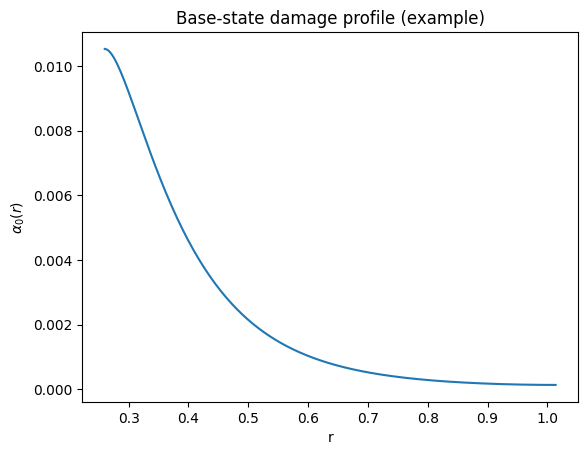

In [14]:
import numpy as np
import matplotlib.pyplot as plt



# Parameters (example)
A_val = 0.2
B_val = 1.0
mu_val = 1.0
Gc_val = 1.0
ell_val = 0.1
Jm_val = 1e9  # irrelevant for NeoHookean, but included in the signatures

eq = equilibrium.EquilibriumProblem(
    A=A_val, B=B_val, mu=mu_val, Gc=Gc_val, ell=ell_val, damage_model="AT2", Jm=Jm_val,
    dda_fun=sym.dda_f
)

lambda_a = 1.3
P = eq.compute_inner_pressure_from_lambda_a(lambda_a)
print("lambda_a =", lambda_a, "  inner pressure P =", P)

# Plot alpha_0(r)
r_grid = np.linspace(eq.a, eq.b, 250)
alpha_vals = np.array([eq.alpha(r) for r in r_grid])
plt.figure()
plt.plot(r_grid, alpha_vals)
plt.xlabel("r")
plt.ylabel(r"$\alpha_0(r)$")
plt.title("Base-state damage profile (example)")
plt.show()


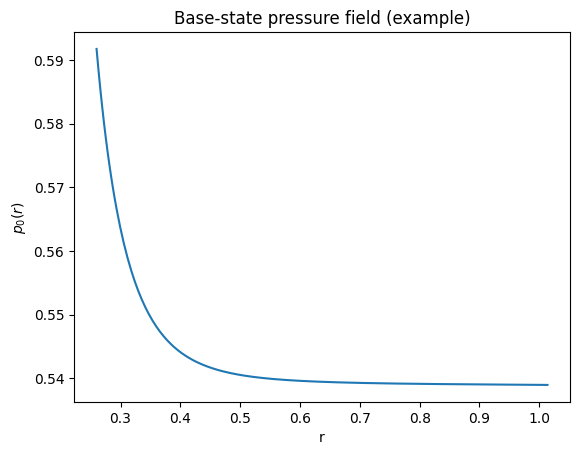

In [15]:
# Plot p0(r) reconstructed in equilibrium.py (via sigma_rr relation)
p0_vals = np.array([eq.pressure(r) for r in r_grid])
plt.figure()
plt.plot(r_grid, p0_vals)
plt.xlabel("r")
plt.ylabel(r"$p_0(r)$")
plt.title("Base-state pressure field (example)")
plt.show()
